In [1]:
# This is code for loading the libraries needed for the assignment
import numpy as np
from casadi import *
import scipy.linalg as la
import matplotlib.pyplot as plt
import minecraftControl as mc

env = mc.constrainedCar()

%matplotlib inline

# The Car Environment

In the next problem we will use MPC on a vehicle which is not well-approximated by a linear time-invariant system. As a result, the optimization problem used in MPC is non-convex, and cannot be solved exactly. Regardless, we will see that MPC can drive the vehicle to a goal state. (Most of the time.)

Here is a simulation with random inputs.

Text(0,0.5,'u')

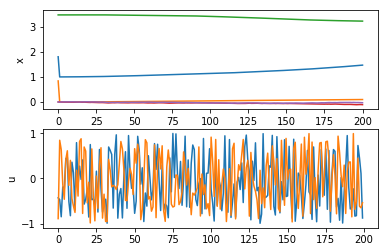

In [2]:
# We need to first call reset to initialize the state
x = env.reset()
X_traj = [x]
U_traj = []


for _ in range(200):
    # Randomly generate a feasible input
    u = env.action_space.sample()
    #u = np.array([0,.5])
    x,r,done,info = env.step(u)
    
    # Saving the state and action sequences
    X_traj.append(x)
    U_traj.append(u)
    
    # Render shows the video
    # If you don't want video, comment the line out.
    env.render()
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break
    
env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')

Here is a description of the dynamics, the constraints, and the costs used for MPC.

In [3]:

# The dynamics are defined below 


# We'll just define it using CasADi symbolics
gain = env.gain
dt = env.dt

x = MX.sym('x',5)
px = x[0]
py = x[1]
theta = x[2]
v = x[3]
omega = x[4]


u = MX.sym('u',2)
uF = u[0]
uTau = u[1]

x_dot = vertcat(v*cos(theta),
                v*sin(theta),
                omega,
                gain * uF,
                gain * uTau)

# This is the description of the dynamics
x_next = x + dt * x_dot

# This creates a callable function that can implement the dynamics
# It will return a CasADi vector,
dynamics = Function('dynamics',[x,u],[x_next])

# Here is the step loss
# Note that it only depends on the state, and does not depend 
loss =  1* px**2 + 1 * py**2 + 2 * v**2 + .1 * omega**2
step_loss = Function('step_loss',[x,u],[loss])


# No final cost
final_cost = Function('final_cost',[x],[0. ])
c = np.inf

# The constraints
tighten = 1e-3
step_constraint = Function('step_constraint',[x,u],[vertcat(x,u)])
step_lb = np.hstack([env.observation_space.low+tighten,env.action_space.low+tighten])
step_ub = np.hstack([env.observation_space.high-tighten,env.action_space.high-tighten])



# Question

Simulate the vehicle using an MPC controller. If you have it working, it should drive the vehicle to the center.
A horizon of $N=50$ should give reasonable behavior. Experiment with changing the step loss and the horizon to improve the behavior.




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



Text(0,0.5,'u')

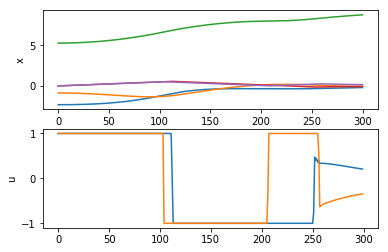

In [4]:
# Solution
N = 50
import mpc
mpcTest = mpc.buildMPCController(5,2,N,dynamics,
                                 step_constraint,step_lb,step_ub,
                                 step_loss,final_cost,c)

# We need to first call reset to initialize the state
x = env.reset()
X_traj = [x]
U_traj = []


for _ in range(300):
    # Randomly generate a feasible input
    u = mpcTest(x)
    #u = np.array([0,.5])
    x,r,done,info = env.step(u)
    
    # Saving the state and action sequences
    X_traj.append(x)
    U_traj.append(u)
    
    # Render shows the video
    # If you don't want video, comment the line out.
    env.render()
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break
    
env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')

In [8]:
# Build your simulation here.

# Noisy Ball

Recall the ball environment from last homework. Recall that the dynamics had the form

$$x(k+1) = Ax(k) + Bu(k)$$

where $A$ and $B$ are given as below.

In [7]:
env = mc.constrainedBall()
dt = env.dt
A = np.array([[1,0,3 *dt,0],
              [0,1,0,3 * dt],
              [0,0,1,0],
              [0,0,0,1]])

B = np.array([[0,0],
              [0,0],
              [dt,0],
              [0,dt]])

Say instead that the dynamics are given by

$$x(k+1) = A x(k) + B(u(k) + d(k)),$$

where $d(k)$ random forces with components generated uniformly over $[-.1,.1]$. 

* Modify your simulation to include the input disturbances, $d(k)$. 
* Modify your MPC controller to ensure that state remains feasible.

Text(0,0.5,'u')

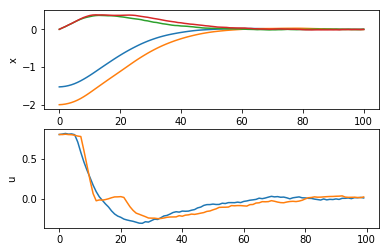

In [8]:
# Solution

import numpy.random as rnd 
Q = np.eye(4)
R = np.eye(2)
S = la.solve_discrete_are(A,B,Q,R)
Omega = R + B.T @S.T @ B
K = -la.solve(Omega,B.T@S@A)

c = 5.

import mpc
        
        
    
N = 60
def dynamics(x,u):
    return A@x + B@u

def step_constraint(x,u):
    return vertcat(x,u)

# Just made the constraights tighter
tighten = 1e-1
xTighten = 1e-2
uTighten = 2e-1
step_lb = np.hstack([env.observation_space.low+xTighten,env.action_space.low+uTighten])
step_ub = np.hstack([env.observation_space.high-xTighten,env.action_space.high-uTighten])

def step_loss(x,u):
    return x.T @ Q @ x + u.T @ R @ u 

def final_cost(x):
    return x.T @ S @ x


mpcTest = mpc.buildMPCController(4,2,N,dynamics,
                                step_constraint,step_lb,step_ub,
                                step_loss,final_cost,c)


# Simulate and Plot
x = env.reset()
X_traj = [x]
U_traj = []

x_pred = np.copy(x)
X_pred = [x_pred]

x_nom = x

for _ in range(100):
    # Randomly Generate an input
    
    # Nominal input
    u_nom = mpcTest(x_nom)
    if u_nom is None:
        print('MPC control unsuccessful')
        break
        
    u = u_nom + K @ (x-x_nom)
    # This is the disturbance
    d = .1 * 2 * (rnd.rand(2)-.5)
    x,r,done,info = env.step(u + d)

    x_nom = A @ x_nom + B @ u_nom
    
    # Saving the state and action sequences
    X_traj.append(x)
    U_traj.append(u)
    
    # Render shows the video
    # If you don't want to render, comment the line out.
    env.render()
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break
    
env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
X_pred = np.array(X_pred)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')